## Exploratory analysis of the US Airport Dataset

This dataset contains data for 25 years[1995-2015] of flights between various US airports and metadata about these routes. Taken from Bureau of Transportation Statistics, United States Department of Transportation.

Let's see what can we make out of this!

In [1]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pass_air_data = pd.read_csv('datasets/passengers.csv')

In the `pass_air_data` dataframe we have the information of number of people that fly every year on a particular route on the list of airlines that fly that route.

In [59]:
pass_air_data.head()

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
0,0,1990,ABE,ACY,{'US Airways Inc.'},73.0
1,1,1990,ABE,ATL,{'Eastern Air Lines Inc.'},73172.0
2,2,1990,ABE,AVL,{'Westair Airlines Inc.'},0.0
3,3,1990,ABE,AVP,"{'Westair Airlines Inc.', 'US Airways Inc.', '...",8397.0
4,4,1990,ABE,BHM,{'Eastern Air Lines Inc.'},59.0


In [61]:
# Create a MultiDiGraph from this dataset
passenger_graph = nx.from_pandas_edgelist(pass_air_data, 
                                          source='ORIGIN', 
                                          target='DEST', 
                                          edge_attr=['YEAR', 'PASSENGERS', 'UNIQUE_CARRIER_NAME'], 
                                          create_using=nx.MultiDiGraph())

### Cleveland to Chicago, how many people fly this route?

In [4]:
passenger_graph['CLE']['ORD'][25]

{'YEAR': 2015,
 'PASSENGERS': 409943.0,
 'UNIQUE_CARRIER_NAME': "{'Frontier Airlines Inc.', 'SkyWest Airlines Inc.', 'Republic Airlines', 'ExpressJet Airlines Inc.', 'American Airlines Inc.', 'Swift Air, LLC', 'GoJet Airlines LLC d/b/a United Express', 'Trans States Airlines', 'Envoy Air', 'Spirit Air Lines', 'United Air Lines Inc.', 'Shuttle America Corp.'}"}

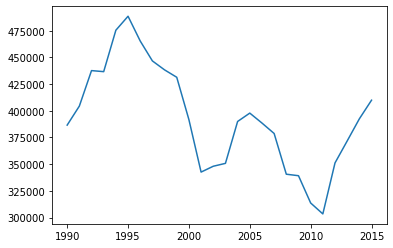

In [62]:
temp = [(i['YEAR'], i['PASSENGERS'])for i in dict(passenger_graph['CLE']['ORD']).values()]
x, y = zip(*temp)
plt.plot(x, y)
plt.show()

## Exercise

Find the busiest route in 1990 and in 2015 according to number of passengers, and plot the time series of number of passengers on these routes.

You can use the DataFrame instead of working with the network. It will be faster ;)
[5 mins]

In [6]:
temp = pass_air_data.groupby(['YEAR'])['PASSENGERS'].transform(max) == pass_air_data['PASSENGERS']

In [7]:
pass_air_data[temp][pass_air_data.YEAR.isin([1990, 2015])]

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
3917,3917,1990,LAX,HNL,"{'Heavylift Cargo Airlines Lt', 'Hawaiian Airl...",1827164.0
445978,445978,2015,LAX,SFO,"{'Hawaiian Airlines Inc.', 'Delta Air Lines In...",1869066.0


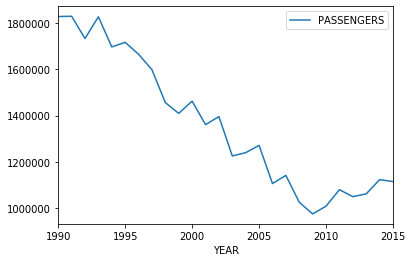

In [8]:
pass_air_data[(pass_air_data['ORIGIN'] == 'LAX') & (pass_air_data['DEST'] == 'HNL')].plot('YEAR', 'PASSENGERS')

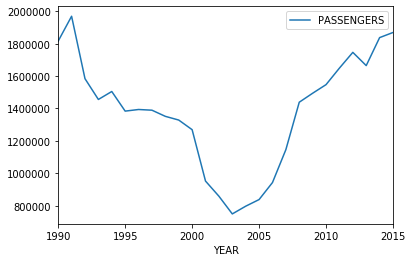

In [9]:
pass_air_data[(pass_air_data['ORIGIN'] == 'LAX') & (pass_air_data['DEST'] == 'SFO')].plot('YEAR', 'PASSENGERS')

So let's have a look at the important nodes in this network, i.e. important airports in this network. We'll use pagerank, betweenness centrality and degree centrality.

In [10]:
# nx.pagerank(passenger_graph)

In [10]:
def year_network(G, year):
    temp_g = nx.DiGraph()
    for i in G.edges(data=True):
        if i[2]['YEAR'] == year:
            temp_g.add_edge(i[0], i[1], weight=i[2]['PASSENGERS'])
    return temp_g

In [11]:
pass_2015 = year_network(passenger_graph, 2015)

In [12]:
len(pass_2015)

1258

In [13]:
len(pass_2015.edges())

25354

In [14]:
# Load in the GPS coordinates of all the airports
lat_long = pd.read_csv('datasets/GlobalAirportDatabase.txt', delimiter=':', header=None)

In [63]:
lat_long[lat_long[1].isin(list(pass_2015.nodes()))]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1321,EGYC,CLF,COLTISHALL,COLTISHALL,ENGLAND,52,45,17,N,1,21,26,E,21,52.755,1.357
3380,KABI,ABI,ABILENE RGNL,ABILENE,USA,32,24,40,N,99,40,54,W,546,32.411,-99.682
3381,KABQ,ABQ,NaN,ALBUQUERQUE,USA,0,0,0,U,0,0,0,U,0,0.000,0.000
3382,KACK,ACK,NANTUCKET MEM,NANTUCKET,USA,41,15,10,N,70,3,36,W,15,41.253,-70.060
3383,KACT,ACT,WACO RGNL,WACO,USA,31,36,40,N,97,13,49,W,158,31.611,-97.230
3384,KACY,ACY,ATLANTIC CITY INTERNATIONAL,ATLANTIC CITY,USA,39,27,27,N,74,34,37,W,23,39.458,-74.577
3386,KADW,ADW,ANDREWS AFB,CAMP SPRINGS,USA,38,48,38,N,76,52,1,W,86,38.811,-76.867
3387,KAEX,AEX,ALEXANDRIA INTERNATIONAL,ALEXANDRIA,USA,31,19,38,N,92,32,54,W,28,31.327,-92.548
3389,KAGS,AGS,AUGUSTA RGNL AT BUSH FLD,BUSH FIELD,USA,33,22,11,N,81,57,52,W,44,33.370,-81.964
3391,KALB,ALB,ALBANY INTERNATIONAL,ALBANY,USA,42,44,53,N,73,48,10,W,87,42.748,-73.803


In [16]:
pos_dict = {}
for airport in lat_long[lat_long[1].isin(list(pass_2015.nodes()))].iterrows():
    pos_dict[airport[1][1]] = (airport[1][15], airport[1][14]) 

## Exercise

Using the position dictionary `pos_dict` create a plot of the airports, only the nodes not the edges.

- As we don't have coordinates for all the airports we have to create a subgraph first.
- Use `nx.subgraph(Graph, iterable of nodes)` to create the subgraph
- Use `nx.draw_networkx_nodes(G, pos)` to map the nodes. 

or 

- Just use a scatter plot :)

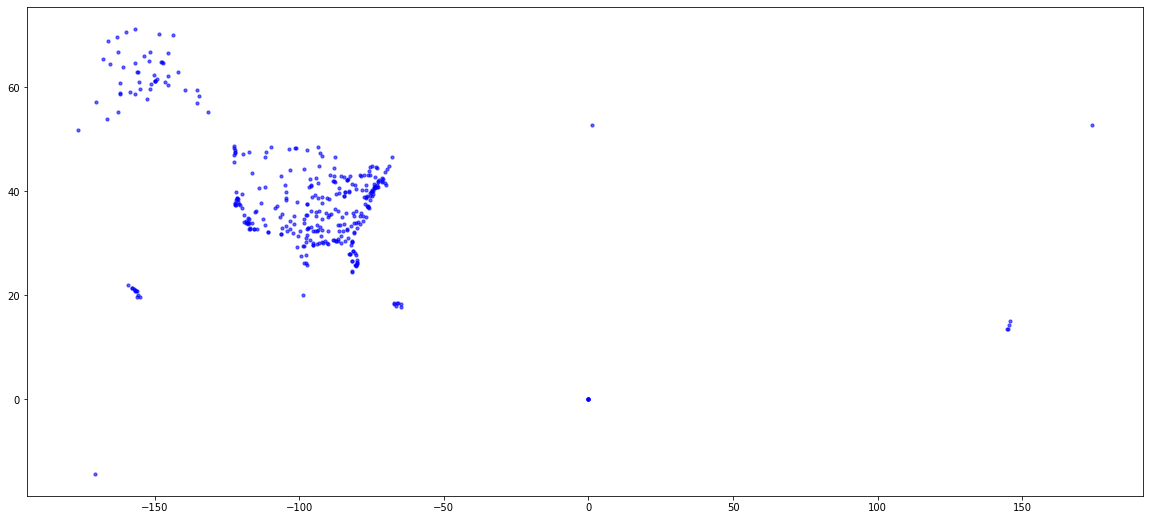

In [64]:
plt.figure(figsize=(20, 9))
G = nx.subgraph(pass_2015, pos_dict.keys())
nx.draw_networkx_nodes(G, pos=pos_dict, node_size=10, alpha=0.6, node_color='b')
# nx.draw_networkx_edges(G, pos=pos_dict, width=0.1, arrows=False)
plt.show()

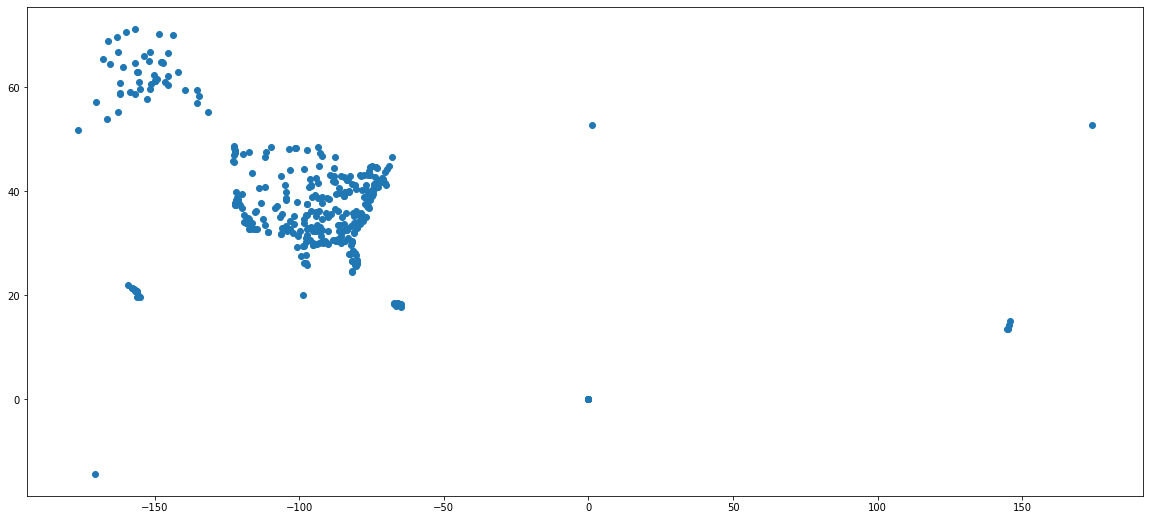

In [19]:
plt.figure(figsize=(20, 9))
x = [i[0] for i in pos_dict.values()]
y = [i[1] for i in pos_dict.values()]
plt.scatter(x, y)

### What about degree distribution of this network?

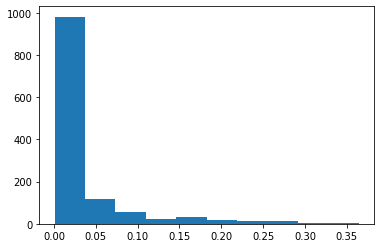

In [20]:
plt.hist(list(nx.degree_centrality(pass_2015).values()))
plt.show()

Let's plot a log log plot to get a better overview of this.

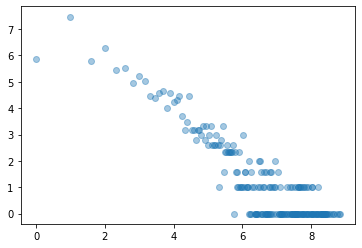

In [21]:
d = {}
for i, j in dict(nx.degree(pass_2015)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log2(list((d.keys())))
y = np.log2(list(d.values()))
plt.scatter(x, y, alpha=0.4)
plt.show()

### Directed Graphs

![title](images/pagerank.png)

In [22]:
G = nx.DiGraph()

G.add_edge(1, 2, weight=1)

# print(G.edges())
# G[1][2]
# G[2][1]
# G.is_directed()
# type(G)

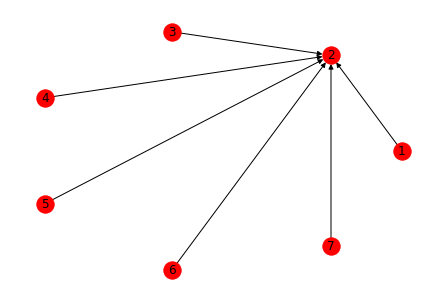

In [23]:
G.add_edges_from([(1, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2)])
nx.draw_circular(G, with_labels=True)

In [24]:
G.in_degree()

InDegreeView({1: 0, 2: 6, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0})

In [25]:
nx.pagerank(G)

{1: 0.0826448180198328,
 2: 0.5041310918810031,
 3: 0.0826448180198328,
 4: 0.0826448180198328,
 5: 0.0826448180198328,
 6: 0.0826448180198328,
 7: 0.0826448180198328}

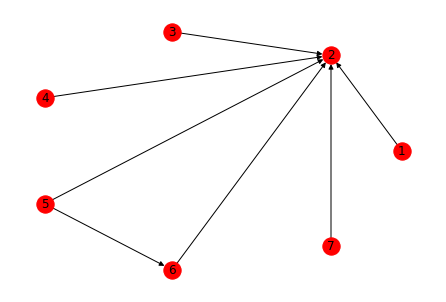

In [26]:
G.add_edge(5, 6)
nx.draw_circular(G, with_labels=True)

In [27]:
nx.pagerank(G)

{1: 0.08024854052495894,
 2: 0.4844028780560986,
 3: 0.08024854052495894,
 4: 0.08024854052495894,
 5: 0.08024854052495894,
 6: 0.11435441931910648,
 7: 0.08024854052495894}

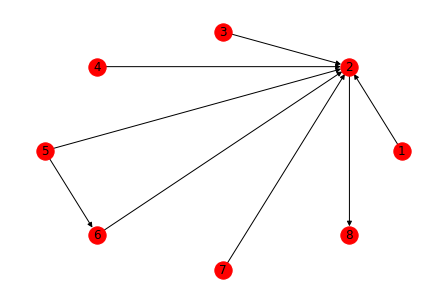

In [28]:
G.add_edge(2, 8)
nx.draw_circular(G, with_labels=True)

In [29]:
nx.pagerank(G)

{1: 0.05378612718073915,
 2: 0.3246687852772877,
 3: 0.05378612718073915,
 4: 0.05378612718073915,
 5: 0.05378612718073915,
 6: 0.0766454192258098,
 7: 0.05378612718073915,
 8: 0.3297551595932067}

### Moving back to Airports

In [30]:
sorted(nx.pagerank(pass_2015, weight=None).items(), key=lambda x:x[1], reverse=True)[:10]

[('ANC', 0.010425531156396332),
 ('HPN', 0.008715287139161587),
 ('FAI', 0.007865131822111036),
 ('DFW', 0.007168038232113773),
 ('DEN', 0.006557279519803018),
 ('ATL', 0.006367579588749718),
 ('ORD', 0.006178836107660135),
 ('YIP', 0.005821525504523931),
 ('ADQ', 0.005482597083474197),
 ('MSP', 0.005481962582230961)]

In [31]:
sorted(nx.betweenness_centrality(pass_2015).items(), key=lambda x:x[1], reverse=True)[0:10]

[('ANC', 0.28907458480586606),
 ('FAI', 0.08042857784594384),
 ('SEA', 0.06745549919241699),
 ('HPN', 0.06046810178534726),
 ('ORD', 0.045544143864829294),
 ('ADQ', 0.040170160000905696),
 ('DEN', 0.038543251364241436),
 ('BFI', 0.03811277548952854),
 ('MSP', 0.03774809342340624),
 ('TEB', 0.036229439542316354)]

In [32]:
sorted(nx.degree_centrality(pass_2015).items(), key=lambda x:x[1], reverse=True)[0:10]

[('ATL', 0.3643595863166269),
 ('ORD', 0.354813046937152),
 ('DFW', 0.3420843277645187),
 ('MSP', 0.3261734287987271),
 ('DEN', 0.31821797931583135),
 ('ANC', 0.3046937151949085),
 ('MEM', 0.29196499602227527),
 ('LAX', 0.2840095465393795),
 ('IAH', 0.28082736674622116),
 ('DTW', 0.27446300715990457)]

'ANC' is the airport code of Anchorage airport, a place in Alaska, and according to pagerank and betweenness centrality it is the most important airport in this network Isn't that weird? Thoughts?

related blog post: https://toreopsahl.com/2011/08/12/why-anchorage-is-not-that-important-binary-ties-and-sample-selection/

Let's look at weighted version, i.e taking into account the number of people flying to these places.

In [33]:
sorted(nx.betweenness_centrality(pass_2015, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('SEA', 2.2656145673621046e+50),
 ('ANC', 1.4996592705774285e+49),
 ('CDV', 1.1625885650735055e+49),
 ('ADQ', 8.328664868877188e+48),
 ('BFI', 6.99097447478957e+48),
 ('PHX', 3.84552515586718e+48),
 ('PDX', 3.120901981185909e+48),
 ('LRD', 4.583490839909188e+47),
 ('SIT', 1.7910862390475677e+46),
 ('FAI', 1.137539313512378e+46)]

In [34]:
sorted(nx.pagerank(pass_2015, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('ATL', 0.037535963029303135),
 ('ORD', 0.028329766122739346),
 ('SEA', 0.028274564067008245),
 ('ANC', 0.027127866647567035),
 ('DFW', 0.02570050418889442),
 ('DEN', 0.025260024346433315),
 ('LAX', 0.02394043498608451),
 ('PHX', 0.018373176636420224),
 ('CLT', 0.01780703930063076),
 ('LAS', 0.017649683141049966)]

## How reachable is this network?

We calculate the average shortest path length of this network, it gives us an idea about the number of jumps we need to make around the network to go from one airport to any other airport in this network.

In [36]:
# nx.average_shortest_path_length(pass_2015)

Wait, What??? This network is not connected. That seems like a really stupid thing to do.

In [35]:
list(nx.weakly_connected_components(pass_2015))

[{'LAL',
  'SVA',
  'UXI',
  'AMA',
  'DQY',
  'FAQ',
  'MMH',
  'VWN',
  'LEX',
  'TAL',
  'MFD',
  'LBB',
  'LOZ',
  'TDF',
  'MYF',
  'VZM',
  'MRY',
  'FYU',
  'BTL',
  'OFF',
  'FLL',
  'NUL',
  'SWF',
  'EWR',
  'DHN',
  'WA1',
  'APC',
  'WA6',
  'NAD',
  'CRP',
  'WSB',
  'TLH',
  'VAK',
  'BIL',
  'JWY',
  'VIK',
  'GAM',
  'JZY',
  'NME',
  'PIA',
  'DET',
  'FWH',
  'PBX',
  'FPR',
  'SC1',
  'GSO',
  'OWB',
  'PTU',
  'TVL',
  'EEN',
  'WWD',
  'TMB',
  'KLL',
  'AEX',
  'TKE',
  'FKL',
  'COE',
  'TUL',
  'XXY',
  'ORL',
  'UMT',
  'OSU',
  'RDG',
  'HSL',
  'CUW',
  'LWM',
  'ILN',
  'MA2',
  'BFF',
  'SNS',
  'GCC',
  'KCC',
  'BFM',
  'ARA',
  'SBN',
  'PLN',
  'EVV',
  'ROG',
  '06A',
  'NCN',
  'LNS',
  'BOK',
  'ONH',
  'KEK',
  'II3',
  'VZE',
  'AL3',
  'EKA',
  'SEA',
  'TRM',
  'ZXT',
  'BFD',
  'STS',
  'EGV',
  'VWD',
  'DE2',
  'PSM',
  'MTJ',
  'A27',
  'STL',
  'GA6',
  'IKO',
  'WAA',
  'FMH',
  'MQJ',
  'RAP',
  'RWI',
  'ME3',
  'TUP',
  'LIT',
  'XXP',
 

### SPB, SSB, AIK anyone?

In [36]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['ORIGIN'] == 'AIK')]

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
433338,433338,2015,AIK,AIK,{'Wright Air Service'},0.0


In [37]:
pass_2015.remove_nodes_from(['SPB', 'SSB', 'AIK'])

In [38]:
nx.is_weakly_connected(pass_2015)

True

In [39]:
nx.is_strongly_connected(pass_2015)

False

### Strongly vs weakly connected graphs.

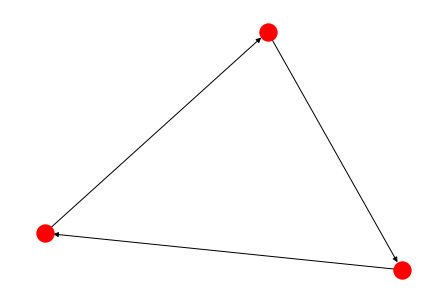

In [40]:
G = nx.DiGraph()
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 1)
nx.draw(G)

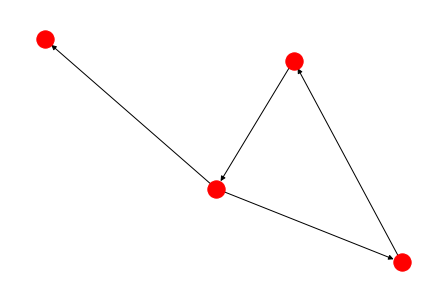

In [41]:
G.add_edge(3, 4)
nx.draw(G)

In [42]:
nx.is_strongly_connected(G)

False

In [43]:
list(nx.strongly_connected_components(pass_2015))

[{'BCE'},
 {'WA3'},
 {'WA9'},
 {'TIW'},
 {'RQV'},
 {'SUA'},
 {'POU'},
 {'MA5'},
 {'MXF'},
 {'TSP'},
 {'MSV'},
 {'AST'},
 {'XXU'},
 {'OR2'},
 {'CLG'},
 {'QQN'},
 {'WVI'},
 {'CO3'},
 {'BOK'},
 {'XXY'},
 {'ZXC'},
 {'ZXT'},
 {'C1A'},
 {'ELN'},
 {'BKE'},
 {'EKI'},
 {'MA4'},
 {'MI6'},
 {'TMB'},
 {'XWF'},
 {'LZU'},
 {'GUF'},
 {'N1Y'},
 {'DKK'},
 {'TIX'},
 {'MRF'},
 {'VAD'},
 {'HKS',
  'A35',
  'NJ1',
  'LAL',
  'RFD',
  'GRR',
  'YKM',
  'UXI',
  'GGG',
  'SVA',
  'IAH',
  'CDB',
  'MLU',
  'GRK',
  'SVN',
  'WBB',
  'AMA',
  'ELM',
  'AUO',
  'SSC',
  'ROW',
  'LGU',
  'FAQ',
  'MVN',
  'IAG',
  'MMI',
  'MKC',
  'TLF',
  'ROC',
  'MMH',
  'WYS',
  'VWN',
  'FCA',
  'KWP',
  'QQB',
  'MIA',
  'RSJ',
  'MI2',
  'CGI',
  'LMA',
  'DQU',
  'A07',
  'EUG',
  'LEX',
  'DVL',
  'TAL',
  'LKV',
  'HLN',
  'SCH',
  'NQX',
  'HKY',
  'BID',
  'CEZ',
  'UGS',
  'MFD',
  'SQA',
  'LBB',
  'DRT',
  'LOZ',
  'LKP',
  'DLH',
  'TDF',
  'SHD',
  'MYF',
  'MDT',
  'VZM',
  'AVP',
  'BLI',
  'NKI',
  'FLG',


In [44]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['DEST'] == 'TSP')]

,Unnamed: 0,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
450245,450245,2015,ONT,TSP,{'Federal Express Corporation'},0.0


In [45]:
pass_2015_strong = max(nx.strongly_connected_component_subgraphs(pass_2015), key=len)

In [46]:
len(pass_2015_strong)

1190

In [47]:
nx.average_shortest_path_length(pass_2015_strong)

3.174661992635574

#### Exercise! (Actually this is a game :D)

How can we decrease the avg shortest path length of this network?

Think of an effective way to add new edges to decrease the avg shortest path length.
Let's see if we can come up with a nice way to do this, and the one who gets the highest decrease wins!!!

The rules are simple:
- You can't add more than 2% of the current edges( ~500 edges)

[10 mins]

In [48]:
sort_degree = sorted(nx.degree_centrality(pass_2015_strong).items(), key=lambda x:x[1], reverse=True)
top_count = 0
for n, v in sort_degree:
    count = 0
    for node, val in sort_degree:
        if node != n:
            if node not in pass_2015_strong.adj[n]:
                pass_2015_strong.add_edge(n, node)
                count += 1
                if count == 25:
                    break
    top_count += 1
    if top_count == 20:
        break

In [49]:
nx.average_shortest_path_length(pass_2015_strong)

3.0888508809747615

### What about airlines? Can we find airline specific reachability?

In [50]:
passenger_graph['JFK']['SFO'][25]

{'YEAR': 2015,
 'PASSENGERS': 1179941.0,
 'UNIQUE_CARRIER_NAME': "{'Delta Air Lines Inc.', 'Virgin America', 'American Airlines Inc.', 'Sun Country Airlines d/b/a MN Airlines', 'JetBlue Airways', 'Vision Airlines', 'United Air Lines Inc.'}"}

In [51]:
def str_to_list(a):
    return a[1:-1].split(', ')

In [52]:
for i in str_to_list(passenger_graph['JFK']['SFO'][25]['UNIQUE_CARRIER_NAME']):
    print(i)

'Delta Air Lines Inc.'
'Virgin America'
'American Airlines Inc.'
'Sun Country Airlines d/b/a MN Airlines'
'JetBlue Airways'
'Vision Airlines'
'United Air Lines Inc.'


In [53]:
%%time
for origin, dest in passenger_graph.edges():
    for key in passenger_graph[origin][dest]:
        passenger_graph[origin][dest][key]['airlines'] = str_to_list(passenger_graph[origin][dest][key]['UNIQUE_CARRIER_NAME'])

CPU times: user 14.9 s, sys: 35.1 ms, total: 14.9 s
Wall time: 14.9 s


### Exercise

Play around with United Airlines network.

- Extract a network for United Airlines flights from the metagraph `passenger_graph` for the year 2015
- Make sure it's a weighted network, where weight is the number of passengers.
- Find the number of airports and connections in this network
- Find the most important airport, according to PageRank and degree centrality.

In [54]:
united_network = nx.DiGraph()
for origin, dest in passenger_graph.edges():
    if 25 in passenger_graph[origin][dest]:
        if "'United Air Lines Inc.'" in passenger_graph[origin][dest][25]['airlines']:
            united_network.add_edge(origin, dest, weight=passenger_graph[origin][dest][25]['PASSENGERS'])

In [55]:
len(united_network)

134

In [58]:
len(united_network.edges())

1097

In [56]:
sorted(nx.pagerank(united_network, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('ORD', 0.09229686412847604),
 ('DEN', 0.06951536832747153),
 ('LAX', 0.05547087049076451),
 ('SFO', 0.04520212084776551),
 ('IAH', 0.04398280474534501),
 ('EWR', 0.03754166218607773),
 ('ATL', 0.034778751100523315),
 ('DFW', 0.03419728511206331),
 ('PHX', 0.025365344038763896),
 ('MSP', 0.022269133819322266)]

In [57]:
sorted(nx.degree_centrality(united_network).items(), key=lambda x:x[1], reverse=True)[0:10]

[('ORD', 1.1729323308270676),
 ('DEN', 0.9172932330827067),
 ('IAH', 0.8195488721804511),
 ('EWR', 0.744360902255639),
 ('SFO', 0.5789473684210527),
 ('LAX', 0.5338345864661653),
 ('IAD', 0.5112781954887218),
 ('CLE', 0.39849624060150374),
 ('STL', 0.3609022556390977),
 ('PHL', 0.3308270676691729)]

### Exercise

We are in Cleveland so what should we do?

Obviously we will make a time series of number of passengers flying out of Cleveland with United Airlines over the years.

There are 2 ways of doing it.
- Create a new multidigraph specifically for this exercise.

OR

- exploit the `pass_air_data` dataframe.

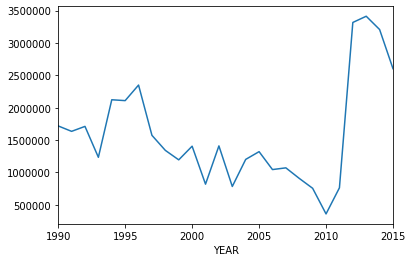

In [58]:
pass_air_data[(pass_air_data.ORIGIN == 'CLE') &
              (pass_air_data.UNIQUE_CARRIER_NAME.str.contains('United Air Lines Inc.'))
             ].groupby('YEAR')['PASSENGERS'].sum().plot()